In [2]:
'''
Zé Fonseca

13/01/16

Notes: Data sets at classes and cases inside each dataset is a subclass
'''

import numpy as np
import scipy as sp
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, splrep, splev, bisplrep, bisplev
import sys

%matplotlib inline

# Part 1

## Load data



In [28]:
class fkd:
    def __init__(self,OM=0.31,H0=67.74,w=-1):
        self.OM=OM
        self.H0=H0
        self.w=w
    
    class case1(object):
        pass
    
    class case3(object):
        pass
    
    def get_case1_data(self,filename,sig_mu=0.2):
        
        dados=np.loadtxt(filename)
        self.case1.z=dados[:,0]
        self.case1.mu_o=dados[:,1]
        self.case1.err_mu=sig_mu*np.ones(len(dados[:,0]))
        
    def get_case3_data(self,filename,sig_mu=0.2):
        
        dados=np.loadtxt(filename)
        self.case3.z=dados[:,0]
        self.case3.z2=dados[:,1]
        self.case3.mu_o=dados[:,2]
        self.case3.err_mu=sig_mu*np.ones(len(dados[:,0]))
    
    def get_case1_chain(self,filename):
        
        dados=np.loadtxt(filename)
        
        self.case1.chain_o_m=dados[:,0]
        self.case1.chain_w=dados[:,1]
        self.case1.chain_H0=dados[:,2]
        self.case1.chi2_mcmc=dados[:,3]
      
        
#cosmological functions
#general functions
def H(z,OM,H0,w):
    if w==-1:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM))
    else:
        return H0*sp.sqrt(OM*(1+z)**3+(1-OM)*(1+z)**(3*(w+1)))

c=2.99792e5

def dL(z,OM,H0,w):
    return (1+z)*quad(lambda x:c/H(x,OM,H0,w),0,z)[0]

def mu(z,OM,H0,w):
    return 5*sp.log10(dL(z,OM,H0,w))+25


In [29]:
fd3=fkd()
fd3.get_case1_data('data_fd3_case1_zf.txt')
fd3.get_case3_data('data_fd3_case3_zf.txt')


In [56]:
fd3.get_case1_chain('mcmc_fd3_case1_zf.txt')

# Part 2

## Do the MCMC with zBEAMS to case 3


In [48]:
# Functions
def interpoler_mu(OM,H0,w,z_data):
    z_spl = np.linspace(min(z_data), max(z_data),100)
    mu_spl = np.array([mu(z_spli,OM,H0,w) for z_spli in z_spl])
    mu_spl_rep = splrep(z_spl, mu_spl)
    mu_theory=splev(z_data, mu_spl_rep)
    return mu_theory

#MCMC priors
def prior_om(x):
    if x>=0 and x<=1:
        return 1
    else:
        return 0
    
def prior_w(x):
    if x>=-2 and x<=1:
        return 1
    else:
        return 0
    
def prior_H0(x):
    if x>=30 and x<=100:
        return 1
    else:
        return 0
    
def chi2(mu_o,mu_t,sigma):
    #just for one point
    return (mu_o-mu_t)**2/sigma**2
    
def dmudz(z,mu,OM=0.31,H0=67.74,w=-1):
    return 5/np.log(10)*(1/(1+z)+(1+z)*c/(H(z,OM,H0,w)*10**(mu/5-5)))

def MCMC_zBEAMS(N,data,pgamma=0.91):
    #create arrays
    o_m=np.zeros(N)
    w=np.zeros(N)
    H0=np.zeros(N)
    log_like=np.zeros(N)
    
    #set starting point
    o_m[0]=np.random.rand()*0.1+0.25
    w[0]=np.random.rand()*0.2-1.1
    H0[0]=np.random.rand()*5+65
    
    #first point
    mu_t1=interpoler_mu(o_m[0],H0[0],w[0],data.z)
    mu_t2=interpoler_mu(o_m[0],H0[0],w[0],data.z2)
    chi2_1=chi2(data.mu_o,mu_t1,data.err_mu)
    chi2_2=chi2(data.mu_o,mu_t2,data.err_mu)
    L1=pgamma*np.exp(-chi2_1/2)
    L2=(1-pgamma)*np.exp(-chi2_2/2)
    log_like[0]=sum(np.log(L1+L2))
    #dummy var for acceptance rate
    naccept=0
    for i in range(N-1):
        #if i%5000==0:
        #    print(accept)
            
        #get new point
        o_m[i+1]=o_m[i]+np.random.randn()*0.04
        w[i+1]=w[i]+np.random.randn()*0.04
        H0[i+1]=H0[i]+np.random.randn()*0.9
        
        
        
        if prior_om(o_m[i+1])==0 or prior_w(w[i+1])==0 or prior_H0(H0[i+1])==0:
            r=0.0
            o_m[i+1]=o_m[i]
            w[i+1]=w[i]
            H0[i+1]=H0[i]
            log_like[i+1]=log_like[i]
            naccept+=1
            next
        else:
            #compute next point
            mu_t1=interpoler_mu(o_m[i+1],H0[i+1],w[i+1],data.z)
            mu_t2=interpoler_mu(o_m[i+1],H0[i+1],w[i+1],data.z2)
            chi2_1=chi2(data.mu_o,mu_t1,data.err_mu)
            chi2_2=chi2(data.mu_o,mu_t2,data.err_mu)
            L1=pgamma*np.exp(-chi2_1/2)
            L2=(1-pgamma)*np.exp(-chi2_2/2)
            log_like[i+1]=sum(np.log(L1+L2))
            
            #ratio of likelihoods
            r=np.exp(log_like[i+1]-log_like[i])
            
            #accept or not
            teste=np.random.rand()
            if r<teste:
                o_m[i+1]=o_m[i]
                w[i+1]=w[i]
                H0[i+1]=H0[i]
                log_like[i+1]=log_like[i]
                naccept+=1
                next
            
        #really cool piece of code from Ethan
        inc100 = np.int64(i/(N-2)*100)
        inc50 = np.int64(i/(N-2)*50)
        sys.stdout.write('\r')
        sys.stdout.write('[' + '#'*inc50 + ' '*(50-inc50) + ']' + str(inc100) + '%')
        sys.stdout.flush()
        
    acceptr=(N-naccept)/N*100
    
    data.nsteps=N
    
    data.chain_o_m=o_m
    data.chain_w=w
    data.chain_H0=H0
    data.log_like=log_like
    data.acceptr=acceptr

In [49]:
MCMC_zBEAMS(50000,fd3.case3)
print('\n',fd3.case3.acceptr) 

[##################################################]100%
 12.686


In [50]:
fd3.case3.log_like

array([-648.65276072, -648.65276072, -648.65276072, ..., -643.04017087,
       -643.04017087, -643.04017087])

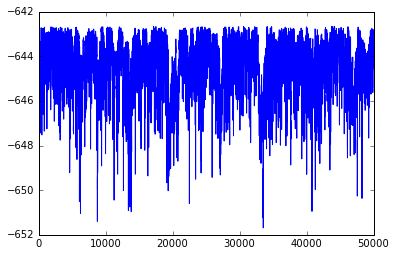

In [51]:
plt.plot(fd3.case3.log_like)

## Make plots

In [104]:
def plot_sct_hist(data1,data2,case,z_noise=False,milne=False,burn_tail=100,thining=1,nb=20,dataset='fd1'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    if z_noise==True:
        title=case+' with photometric error propagation in quadrature'
        caset=case+'_zn'
        om2=data2.zn_chain_o_m[burn_tail::thining]
        w2=data2.zn_chain_w[burn_tail::thining]
        H02=data2.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        title=case+' with photometric error propagation as in Milne'
        caset=case+'_milne'
        om2=data2.milne_chain_o_m[burn_tail::thining]
        w2=data2.milne_chain_w[burn_tail::thining]
        H02=data2.milne_chain_H0[burn_tail::thining]
        
    else:
        title=case
        om2=data2.chain_o_m[burn_tail::thining]
        w2=data2.chain_w[burn_tail::thining]
        H02=data2.chain_H0[burn_tail::thining]
        caset=case
    
    f.text(0.5, 0.95, 'Bias: '+dataset+', Case '+title,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=nb,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=nb,alpha=0.2)
    
    axarr[1,0].scatter(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],color='r',alpha=0.05)
    axarr[1,0].scatter(om2,w2,color='b',alpha=0.05)
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=nb,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=nb,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=nb,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=nb,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_'+dataset+'_'+caset+'_zf.pdf')
    
    plt.show()


def confidence_levels(Hist,N):
    H2d=Hist.ravel()
    H2d = np.sort(H2d)
    tot=np.cumsum(H2d)
    Nmax=H2d[-1]
    N95=H2d[np.argwhere(tot>0.05*N)[0,0]]
    N68=H2d[np.argwhere(tot>0.32*N)[0,0]]
    return Nmax,N68,N95

def plot_contour_hist(data1,data2,case,z_noise=False,milne=False,burn_tail=100,thining=1,nb=20,dataset='fd1'):    
    #o_m,w,H0,case,dataset,,hotext=[66,6000]):
    f, axarr = plt.subplots(2, 2,figsize=(12,8),gridspec_kw = {'width_ratios':[2,1],'height_ratios':[1,2]})
    
    
    Hist_mcmc, omedges,wedges = np.histogram2d(data1.chain_o_m[burn_tail::thining],data1.chain_w[burn_tail::thining],bins=(nb, nb))
    om_c=np.array([(omedges[i]+omedges[i+1])/2 for i in range(len(omedges)-1)])
    w_c=np.array([(wedges[i]+wedges[i+1])/2 for i in range(len(wedges)-1)])
    Neff=len(data1.chain_o_m[burn_tail::thining])
    Nmax,N68,N95=confidence_levels(Hist_mcmc,Neff)
    #plt.plot(om_max,w_max,'rx',ms=10)
    
    bins_om=[round(x*0.025,3) for x in range(0,40)]
    bins_w=[round(x*0.05-2,3) for x in range(0,40)]
    bins_H=[x*0.25+60 for x in range(0,80)]
    
    title=case
    caset=case
    om2=data2.chain_o_m[burn_tail::thining]
    w2=data2.chain_w[burn_tail::thining]
    H02=data2.chain_H0[burn_tail::thining]
    Hist_mcmc2, omedges2,wedges2 = np.histogram2d(om2,w2,bins=(nb, nb))
    om_c2=np.array([(omedges2[i]+omedges2[i+1])/2 for i in range(len(omedges2)-1)])
    w_c2=np.array([(wedges2[i]+wedges2[i+1])/2 for i in range(len(wedges2)-1)])
    Neff2=len(om2)
    Nmax2,N682,N952=confidence_levels(Hist_mcmc2,Neff2)
    
    f.text(0.5, 0.95, 'Bias: '+dataset+', Case '+title,horizontalalignment='center',verticalalignment='top')
    
    om_min=min(np.amin(data1.chain_o_m[burn_tail::thining]),np.amin(om2))
    om_max=max(np.amax(data1.chain_o_m[burn_tail::thining]),np.amax(om2))
    
    w_min=min(np.amin(data1.chain_w[burn_tail::thining]),np.amin(w2))
    w_max=max(np.amax(data1.chain_w[burn_tail::thining]),np.amax(w2))
    
    H0_min=min(np.amin(data1.chain_H0[burn_tail::thining]),np.amin(H02))
    H0_max=max(np.amax(data1.chain_H0[burn_tail::thining]),np.amax(H02))
    
    axarr[0,0].hist(data1.chain_o_m[burn_tail::thining],color='r',bins=bins_om,alpha=0.2)
    axarr[0,0].set_xlim([om_min,om_max])
    axarr[0,0].hist(om2,color='b',bins=bins_om,alpha=0.2)
    
    import matplotlib as mpl
    colors1 = [(1.0, 0.0, 0.0, 0.3),(1.0, 0.0, 0.0, 0.1)] 
    cmap1 = mpl.colors.ListedColormap(colors1)
    colors2 = [(0.0, 0.0, 1.0, 0.3),(0.0, 0.0, 1.0, 0.1)] 
    cmap2 = mpl.colors.ListedColormap(colors2)
    
    axarr[1,0].contourf(om_c,w_c, Hist_mcmc.T,levels=[N95,N68,Nmax], cmap=cmap1)
    axarr[1,0].contourf(om_c2,w_c2, Hist_mcmc2.T,levels=[N952,N682,Nmax2],cmap=cmap2)
    axarr[1,0].plot(0.31,-1,'sk')
    axarr[1,0].set_xlim([om_min,om_max])
    axarr[1,0].set_ylim([w_min,w_max])
    axarr[1,0].set_ylabel(r'$w$')
    axarr[1,0].set_xlabel(r'$\Omega_M$')
    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color='red', label='Simulated')
    blue_patch = mpatches.Patch(color='blue', label='zBEAMS')
    
    axarr[1,0].legend(handles=[red_patch,blue_patch], loc = 'lower left',frameon=False)
    
    axarr[0,1].hist(data1.chain_H0[burn_tail::thining],bins=bins_H,color='r',alpha=0.2)
    axarr[0,1].hist(H02,bins=bins_H,color='b',alpha=0.2)
    axarr[0,1].set_xlim([H0_min,H0_max])
    axarr[0,1].set_xlabel(r'$H_0$')
    
    axarr[1,1].hist(data1.chain_w[burn_tail::thining],bins=bins_w,color='r',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].hist(w2,bins=bins_w,color='b',alpha=0.2,orientation=u'horizontal')
    axarr[1,1].set_ylim([w_min,w_max])
    
    plt.savefig('bias_'+dataset+'_'+caset+'_zf.pdf')
    
    plt.show()
    
def plot_conv_mcmc(data,case,z_noise=False,milne=False,burn_tail=100,thining=1,dataset='fd1'):
    f, axarr = plt.subplots(3,1,figsize=(8,12))
    
    if z_noise==True:
        title=case+' with photometric error propagation in quadrature'
        caset=case+'_zn'
        om=data.zn_chain_o_m[burn_tail::thining]
        w=data.zn_chain_w[burn_tail::thining]
        H0=data.zn_chain_H0[burn_tail::thining]
    elif milne==True:
        title=case+' with photometric error propagation as in Milne'
        caset=case+'_milne'
        om=data.milne_chain_o_m[burn_tail::thining]
        w=data.milne_chain_w[burn_tail::thining]
        H0=data.milne_chain_H0[burn_tail::thining]        
    else:
        title=case
        caset=case
        om=data.chain_o_m[burn_tail::thining]
        w=data.chain_w[burn_tail::thining]
        H0=data.chain_H0[burn_tail::thining]
    
    f.text(0.5, 0.95, 'Convergence: '+dataset+': '+title,
         horizontalalignment='center',
         verticalalignment='top')
    axarr[0].plot(om)
    axarr[0].set_ylim([np.amin(om),np.amax(om)])
    axarr[0].set_ylabel(r'$\Omega_M$')
    
    axarr[1].plot(w)
    axarr[1].set_ylim([np.amin(w),np.amax(w)])
    axarr[1].set_ylabel(r'$w$')
    
    axarr[2].plot(H0)
    axarr[2].set_ylim([np.amin(H0),np.amax(H0)])
    axarr[2].set_ylabel(r'$H_0$')
    
    plt.setp(axarr[0].get_xticklabels(), visible=False)
    plt.setp(axarr[1].get_xticklabels(), visible=False)
    
    plt.savefig('convergence_'+dataset+'_'+caset+'_zf.pdf')
    plt.show()

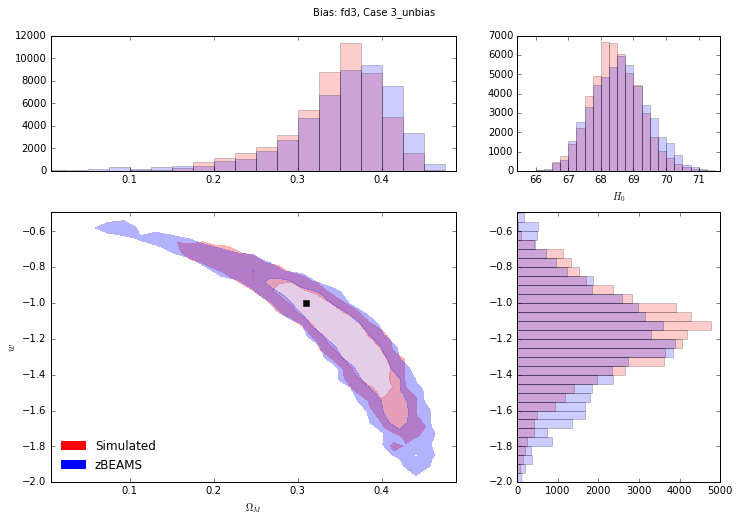

In [105]:
plot_contour_hist(fd3.case1,fd3.case3,'3_unbias',dataset='fd3',nb=25)

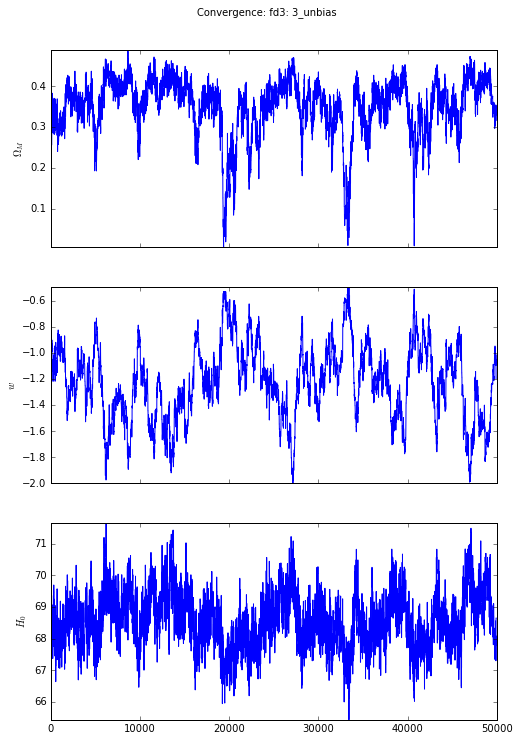

In [106]:
plot_conv_mcmc(fd3.case3,'3_unbias',dataset='fd3')

In [108]:
fd3.case3.log_like

array([-648.65276072, -648.65276072, -648.65276072, ..., -643.04017087,
       -643.04017087, -643.04017087])

In [109]:
def save_mcmc(data,name,z_noise=False,milne=False):
    np.savetxt('mcmc_'+name+'_zf.txt',np.c_[data.chain_o_m,data.chain_w,data.chain_H0,data.log_like],\
                   fmt=['%2.3f','%2.3f','%2.3f','%2.3f'],header='\n'.join(["acceptance rate %.2f" %data.acceptr,\
                                                                           "Om   w   H0   log_like"]))
save_mcmc(fd3.case3,'fd3_case3_zbeams')
